# Compile our corpus and do TF-idf on it.

## Goals: Create corpora out of relevant topic or non-topic documents.
- RDoC topic abstracts as positive corpus
  + Arousal as a first example
- Unrelated abstracts at various distances as negative corpora.

### Positive corpus from all Arousal abstracts

In [5]:
%cd /Users/ccarey/Documents/Projects/NAMI/rdoc/tasks/task_data_temp

/Users/ccarey/Documents/Projects/NAMI/rdoc/tasks/task_data_temp


### Finding the Arousal pubmed ids from MK

In [6]:
import glob
import os
import re

files = glob.glob('/Users/ccarey/Documents/Projects/NAMI/rdoc/results/mk/*AR*mk*ANNOTATED.txt')
files = [os.path.basename(f) for f in files]
p = re.compile('[0-9]{8,8}')
pmids = [p.search(f).group() for f in files if p.search(f)]
print('{} pmids'.format(len(pmids)))
print(pmids)
with open('8_0_2_MK_arousal_pmids', 'wb') as f:
    for pmid in pmids:
        f.write(pmid + '\n')

36 pmids
['25734385', '23647728', '23083918', '22575329', '22379245', '25197810', '25136085', '25126038', '25142564', '25126029', '24470693', '24333377', '24116095', '24101292', '24045586', '23954763', '23646134', '20815182', '20695690', '21699821', '21849230', '25017671', '24725811', '25258728', '25348131', '22379238', '22438994', '23452958', '23709163', '23904684', '23074247', '23088207', '23143607', '23622762', '24770625', '24980898']


### Saving the individual Arousal abstracts and concatenating to create single postive training corpus.

In [7]:
ar_abstracts=!medic --format tsv write --pmid-list '8_0_2_MK_arousal_pmids' 2>/dev/null
ar_abstracts = [a.split('\t', 2) for a in ar_abstracts]

abstracts from other topics

In [8]:
def get_abstracts(pmid_list_file):
    abstracts=!medic --format tsv write --pmid-list {pmid_list_file} 2>/dev/null
    return([a.split('\t', 2) for a in abstracts])

In [9]:
ar_36 = get_abstracts('8_0_2_MK_arousal_pmids')
len(ar_36)

36

In [10]:
ar_1000 = get_abstracts('AR00_1000_ids')
len(ar_1000)

1000

In [11]:
diss_1000 = get_abstracts('diss_1000_ids')
len(diss_1000)

1000

In [12]:
psyc_1000 = get_abstracts('psyc_1000_ids')
len(psyc_1000)

1000

### Calculate TF-idf on the positive training corpus.
These are our **closest similarity** representatives since they are members of the corpus.

**Pattern is: vectorize and transform**

Can be done in 2 steps:
+ CountVectorizer()
+ TfidfTransformer()

Or one step:
+ TfidfVectorizer()

**Possibly use binary parameter of CountVectorizer**

As binary may be more stable for shorter texts.

If we use the stop words, everything gets squished towards a cosine similarity of 0.

Since we are not eliminating stop words in deepdive training, why would we possibly do it here? So we don't.

In [13]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

In [14]:
#vectorizer = CountVectorizer(min_df=1, stop_words = 'english')
#vectorizer = CountVectorizer(min_df=1, max_df = 0.9) # alternate to stop words

In [15]:
vectorizer = CountVectorizer(min_df=1)
vectorizer

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [16]:
transformer = TfidfTransformer(norm='l2')
transformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [17]:
def get_abstract_string(abstracts):
    return([a[2] for a in abstracts])

Similarity among just the Arousal abstracts we annotated

In [18]:
def get_similarity(texts):
    X = vectorizer.fit_transform(a)
    Y = transformer.fit_transform(X)
    return(cosine_similarity(Y))

def upper_k1_triangle_to_arr(matrix):
    '''Upper triangle excluding the main diagonal'''
    return(matrix[np.triu_indices(len(matrix), k=1)])
    
def report_similarity(pairs_matrix):
    pairs = upper_k1_triangle_to_arr(pairs_matrix)
    print('median : {}'.format(np.median(pairs)))
    print('mean : {}'.format(np.mean(pairs)))
    print('min : {}'.format(np.min(pairs)))
    print('max : {}'.format(np.max(pairs)))

In [19]:
import seaborn as sns
%matplotlib inline

median : 0.106927701958
mean : 0.114726599535
min : 0.0393396559378
max : 0.653500778338


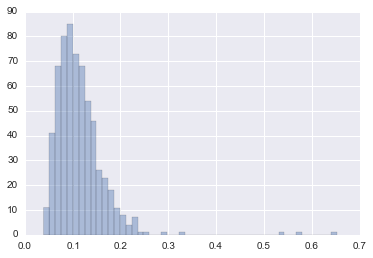

In [637]:
a = get_abstract_string(ar_36)
a_s = get_similarity(a)
report_similarity(a_s)
a_s_arr = upper_k1_triangle_to_arr(a_s)
sns.distplot(a_s_arr, kde=False)

In [638]:
# Check close articles... yes same authors, very similar wording and subject
# np.where(np.isclose(0.653500778338, a_s))
# print(ar_36[9])
# print(ar_36[35])

median : 0.0603569715301
mean : 0.0660531789203
min : 0.00655107521531
max : 0.682021571969


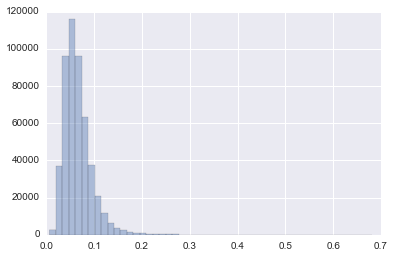

In [641]:
a = get_abstract_string(ar_1000)
a_s = get_similarity(a)
report_similarity(a_s)
a_s_arr = upper_k1_triangle_to_arr(a_s)
sns.distplot(a_s_arr, kde=False)

median : 0.0581692728693
mean : 0.063154637947
min : 0.0
max : 0.568976631244


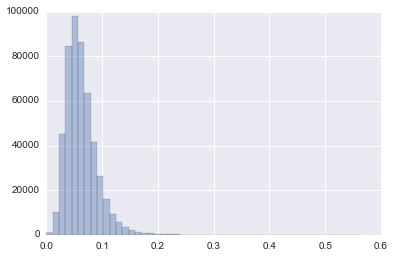

In [639]:
a = get_abstract_string(psyc_1000)
a_s = get_similarity(a)
report_similarity(a_s)
a_s_arr = upper_k1_triangle_to_arr(a_s)
sns.distplot(a_s_arr, kde=False)

median : 0.054595926845
mean : 0.0591052427989
min : 0.00404164998591
max : 0.608155386658
[ 0.60815539  0.51148501  0.58797017  0.52099838  0.55449571  0.55457912]


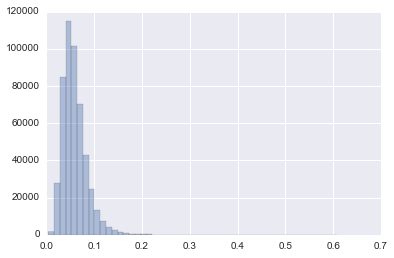

In [643]:
a = get_abstract_string(diss_1000)
a_s = get_similarity(a)
report_similarity(a_s)
a_s_arr = upper_k1_triangle_to_arr(a_s)
print(a_s_arr[a_s_arr > 0.5])
sns.distplot(a_s_arr, kde=False)

Extend to also check simlarity across other abstracts

## lemmatizing with spacy vs. vectorizer.vocabulary without specifying stemmer.
Note, spacy stems, for sklearn CountVectorizer, we need to specify lemmatizer to stem.


In [3]:
import io
import codecs
from spacy.en import English
nlp = English(parser=True, tagger=True) # so we can sentence parse

In [2]:
def spacy_lemma_gt_len(text, length=2):
    '''Create bag of unique lemmas, requiring lemma length > length
    
    Note: setting length to 1 may mess up our postgres arrays as we would
    get commas here, unless we were to quote everything.
    '''
    tokens = []
    #doc = nlp(text.decode('utf8')) #"This is a sentence. Here's another...".decode('utf8'))
    parsed_data = nlp(text) #"This is a sentence. Here's another...".decode('utf8'))
    for token in parsed_data:
        if len(token.lemma_) > length:
            tokens.append(token.lemma_.lower())
    return(list(set(tokens)))



## A. Misc tokenizing and stemming

In [91]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from nltk.stem.porter import PorterStemmer

#######
# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

vect = CountVectorizer(tokenizer=tokenize, stop_words='english') 

# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = WordNetLemmatizer()
#     def __call__(self, doc):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
# vect = CountVectorizer(tokenizer=tokenizer) 

In [93]:
wnl = WordNetLemmatizer()

In [96]:
print(wnl.lemmatize('established'))
print(wnl.lemmatize('churches'))
print(spacy_lemma_gt_len(u'established churches'))
print(tokenize(u'established churches'))
print(stemmer.stem('established'))

established
church
[u'establish', u'church']
[u'establish', u'church']
establish


In [82]:
a = get_abstract_string(ar_36)
lemmas = spacy_lemma_gt_len(a[0].decode(), 1)
lemmas = sorted(lemmas)

X = vect.fit_transform(a[0:1])
vocab_vectorizer = vect.get_feature_names()

print(len(lemmas))
print(len(vocab_vectorizer))
print(len(set(vocab_vectorizer).union(lemmas)))
print(sorted(set(lemmas).difference(vocab_vectorizer)))
print(sorted(set(vocab_vectorizer).difference(lemmas)))

97
84
152
[u'ad.', u'additive', u'although', u'an', u'and', u'arousal', u'as', u'be', u'become', u'both', u'classically', u'combination', u'comorbidity', u'compare', u'conditioned', u'consumption', u'craving', u'dependence', u'disorder', u'either', u'emotion', u'evidence', u'examine', u'finding', u'firmly', u'great', u'have', u'image', u'important', u'in', u'include', u'increase', u'indicate', u'individual', u'laboratory', u'maintenance', u'may', u'memory', u'moreover', u'nature', u'negative', u'no', u'of', u'on', u'or', u'pairing', u'participant', u'personalized', u'physiological', u'posttraumatic', u'reactivity', u'relate', u'responding', u'response', u'salivary', u'salivation', u'self', u'study', u'than', u'that', u'the', u'these', u'this', u'through', u'to', u'well', u'when', u'with']
[u'(', u')', u',', u'.', u'=', u'addit', u'alcohol-rel', u'arous', u'becom', u'classic', u'combin', u'comorbid', u'compar', u'condit', u'consumpt', u'crave', u'depend', u'disord', u'emot', u'evid', u'

In [1]:
a_s = get_similarity(a)
report_similarity(a_s)
a_s_arr = upper_k1_triangle_to_arr(a_s)
sns.distplot(a_s_arr, kde=False)

# For each paper in positive set find at least 1 paper that is most similar...

# Appendices

http://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity

## A.1 example, checking vectorizer results for particular words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
vectorizer = CountVectorizer(min_df=1, stop_words = 'english')

In [610]:
#vectorizer.get_stop_words()

NameError: name 'sklearn' is not defined

In [405]:
a_sub = [a[2] for a in abstracts[0:10]]

X = vectorizer.fit_transform(a_sub) # sparse matrix
X

<10x685 sparse matrix of type '<type 'numpy.int64'>'
	with 901 stored elements in Compressed Sparse Row format>

In [388]:
transformer = TfidfTransformer()
Y = transformer.fit_transform(X)
Y.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.08136766, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.19978123,
         0.07833716,  0.        ],
       [ 0.05184885,  0.        ,  0.        , ...,  0.04407626,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [389]:
print(vectorizer.get_feature_names()[0:100] )
idx = vectorizer.vocabulary_.get('accompanying') # index location
print(X.toarray()[:, idx]) # Only in last of the 5 documents
idx = vectorizer.vocabulary_.get('awake') # index location
print(idx)
print(X.toarray()[:, idx])
print(Y.toarray()[:, idx])
# confirm...
print(re.findall(' awake ', a_sub[0]))
print(re.findall(' awake ', a_sub[1]))
print(re.findall(' awake ', a_sub[3]))

[u'00', u'02', u'05', u'08', u'10', u'12', u'16', u'18', u'19', u'20', u'22', u'25', u'27', u'30', u'332', u'35', u'40', u'45', u'48', u'56', u'70', u'83', u'abdominal', u'ability', u'abnormal', u'absence', u'accompanying', u'account', u'acoustic', u'activation', u'activities', u'activity', u'ad', u'additionally', u'additive', u'affect', u'affected', u'affecting', u'affective', u'affects', u'age', u'aid', u'aim', u'alcohol', u'allele', u'alleles', u'alterations', u'altered', u'amygdala', u'analyses', u'analysis', u'anterior', u'anxiety', u'appetitive', u'arousal', u'arthritis', u'assess', u'assessed', u'assessing', u'assessment', u'assessments', u'associated', u'association', u'associations', u'attention', u'attentional', u'auditory', u'average', u'aversive', u'avoidance', u'awake', u'balance', u'based', u'baseline', u'bases', u'basis', u'behavior', u'behavioral', u'behaviors', u'believed', u'benefit', u'bias', u'biased', u'biological', u'blind', u'blink', u'bloating', u'blocks', u'blu

In [391]:
import numpy
numpy.set_printoptions(threshold=50)
print(X.toarray()[0:10,0:10])
#print(abstracts_subset[0])
#print(abstracts_subset[3])

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 2 1 0]]


## A.2 cosine similarity is 1 - cosine distance

In [393]:
CS = cosine_similarity(Y)
CD = cosine_distances(Y)

In [394]:
(CS + CD)[0:3]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

### Pairwise similarities across all documents
Smaller values are closer document pairs.

In [395]:
# top of matrix
print(CS[0:3])

[[ 1.          0.01372815  0.11179181  0.02057372  0.0123945   0.04210795
   0.03054761  0.02937845  0.01646299  0.02740921]
 [ 0.01372815  1.          0.07356882  0.02758827  0.00635186  0.01900985
   0.05810082  0.00773126  0.00426639  0.12416518]
 [ 0.11179181  0.07356882  1.          0.01493718  0.00983574  0.00716719
   0.01259717  0.01427109  0.0371889   0.01167651]]


In [396]:
# upper triangle without the diagonal
CS[np.triu_indices(n=len(CS), k=1)]

array([ 0.01372815,  0.11179181,  0.02057372,  0.0123945 ,  0.04210795,
        0.03054761,  0.02937845,  0.01646299,  0.02740921,  0.07356882,
        0.02758827,  0.00635186,  0.01900985,  0.05810082,  0.00773126,
        0.00426639,  0.12416518,  0.01493718,  0.00983574,  0.00716719,
        0.01259717,  0.01427109,  0.0371889 ,  0.01167651,  0.09744671,
        0.01414746,  0.03366219,  0.02866423,  0.04793282,  0.00474729,
        0.01022048,  0.0431809 ,  0.00634754,  0.06558308,  0.03459395,
        0.13217066,  0.04834782,  0.01584267,  0.10096319,  0.06062208,
        0.01136721,  0.16567452,  0.01693197,  0.03688224,  0.00896036])

In [397]:
np.median(CS[np.triu_indices(len(CS), k=1)])

0.027409210522198989

## A.2 vectorizing with n-grams

In [386]:
## bigrams
# vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
# X = vectorizer.fit_transform(corpus)
# X

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
transformer

TfidfTransformer(norm=u'l2', smooth_idf=True, sublinear_tf=False,
         use_idf=True)

In [ ]:
counts = 
tfidf = transformer.fit_transform(counts)

## lemmatizing by adding the wordnet lemmatizer
http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes

In [273]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
     def __init__(self):
         self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# first time with NLTK?
# import nltk
# nltk.download() # download packages, or at least the wordnet package

In [274]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('asseses')

u'ass'

In [275]:
vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [277]:
a_sub = [a[2] for a in abstracts[0:5]]
X = vect.fit_transform(a_sub) # sparse matrix
X

<5x499 sparse matrix of type '<type 'numpy.int64'>'
	with 658 stored elements in Compressed Sparse Row format>

In [278]:
print(vect.get_feature_names()[0:100] )
idx = vect.vocabulary_.get('accompanying') # index location
print(X.toarray()[:, idx]) # Only in last of the 5 documents
idx = vect.vocabulary_.get('an') # index location
print(X.toarray()[:, idx]) # In several documents, 2x in 3rd.
# confirm...
print(re.findall(' an ', a_sub[0]))
print(re.findall(' an ', a_sub[1]))
print(re.findall(' an ', a_sub[2]))

[u"'", u"'s", u'(', u')', u',', u'-', u'.', u'.05', u'0.02-0.08', u'0.02-0.08-hz', u'0.56', u'1', u'10-minute', u'10-repeat', u'12', u'2', u'2.8', u'20-minute', u'25.9', u'332', u'40', u'40-hour', u'48', u'83', u';', u'<', u'=', u'a', u'abdominal', u'ability', u'about', u'above', u'accompanying', u'across', u'ad', u'additive', u'affect', u'affected', u'affecting', u'after', u'age', u'aim', u'alcohol', u'alcohol-related', u'allele', u'alone', u'also', u'altered', u'although', u'among', u'an', u'analysis', u'and', u'and/or', u'another', u'anxiety', u'are', u'arousal', u'ass', u'assessed', u'associated', u'association', u'at', u'attention', u'attentional', u'average', u'avoidance/numbing', u'awake', u'base', u'based', u'baseline', u'be', u'become', u'been', u'before', u'behavior', u'benefit', u'between', u'beyond', u'bias', u'biological', u'bloating', u'both', u'bowel', u'bp', u'by', u'called', u'can', u'carry', u'catastrophizing', u'catechol-o-methyl', u'cause', u'change', u'characterist

## A.4 Cautions on small texts suggest smoothing to help
http://www.p-value.info/2013/02/when-tfidf-and-cosine-similarity-fail.html